# Chapter 5 - Some examples of data analysis

In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [2]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'

In [3]:
import numpyro 
import numpyro.distributions as dist 
from numpyro.infer import MCMC, NUTS, Predictive
import jax 
import jax.random as random 
import jax.numpy as jnp 

import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; 
import arviz
#sns.set_style("darkgrid"); 

plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
plt.style.use("dark_background")

numpyro.set_platform('gpu')
numpyro.set_host_device_count(2)

jax.local_devices(), jax.local_device_count()

In [4]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.4.1
jax       : 0.2.10
arviz     : 0.11.2
sys       : 3.8.0 (default, Feb 25 2021, 22:10:10) 
[GCC 8.4.0]
seaborn   : 0.11.1
numpyro   : 0.6.0
numpy     : 1.19.4
pandas    : 1.2.2
scipy     : 1.5.4



In [5]:
rng_key = random.PRNGKey(0)
rng_key, sub = jax.random.split(rng_key)
rng_key

array([4146024105,  967050713], dtype=uint32)

# 5.1 Pearson correlation
The Pearson product-moment correlation coefficient, usually denoted r, is a widely used measure of the relationship between two variables. It ranges from −1, indicating a perfect negative linear relationship, to +1, indicating a perfect positive relationship. A value of 0 indicates that there is no linear relationship. Usually the correlation r is reported as a single point estimate, perhaps together with a frequentist significance test.

But, rather than just having a single number to measure the correlation, it would be nice to have a posterior distribution for r, saying how likely each possible level of correlation was. There are frequentist confidence interval methods that try to do this, as well as various analytic Bayesian results based on asymptotic approximations (e.g., Donner & Wells, 1986).

Inferring the mean and variance of a Gaussian distribution.

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$

$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$

$$ r \sim \text{Uniform} (-1, 1) $$

$$ x_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), 
                                    \begin{bmatrix}
                                            \sigma_{1}^2 & \sigma_{1}\sigma_{2}\\
                                            \sigma_{1}\sigma_{2} & \sigma_{2}^2
                                    \end{bmatrix}^{-1})  
$$

The observed data take the form xi = (xi1, xi2) for the ith observation, and, following the theory behind the correlation coefficient, are modeled as draws from a multivariate Gaussian distribution. The parameters of this distribution are the means μ = (μ1,μ2) and standard deviations σ = (σ1,σ2) of the two variables, and the correlation coefficient r that links them.

In [8]:
# The datasets:
y = np.array( [ 0.8, 102, 1, 98, 0.5, 100, 0.9, 105, 0.7, 103,
        0.4, 110, 1.2, 99, 1.4, 87, 0.6, 113, 1.1, 89, 1.3, 93]
    ).reshape((11, 2))

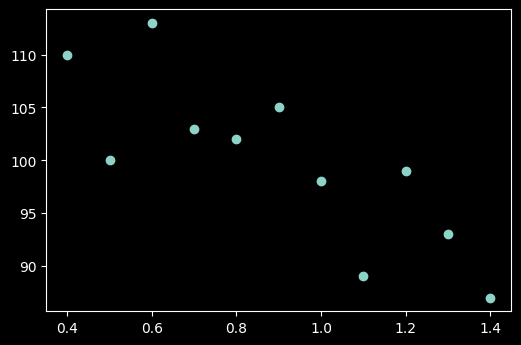

In [9]:
plt.scatter(y[:,0], y[:,1]);

In [10]:
def model51(y=None):
    mu1 = numpyro.sample('mu1', dist.Normal(0., scale=1./jnp.sqrt(0.001)))
    mu2 = numpyro.sample('mu2', dist.Normal(0., scale=1./jnp.sqrt(0.001)))
    mu = jnp.array([mu1, mu2])
    
    lambda1 = numpyro.sample('lamb1', dist.Gamma(0.001, 0.001))
    lambda2 = numpyro.sample('lamb2', dist.Gamma(0.001, 0.001))
    
    r = numpyro.sample('r', dist.Uniform(-1, 1))
    
    # reparametrization
    sig1 = 1. / jnp.sqrt(lambda1)
    sig2 = 1. / jnp.sqrt(lambda2)
    
    cov = jnp.array([[1./lambda1, sig1 * sig2 * r], 
                     [sig1*sig2*r, 1./lambda2]])
    
    # observation
    y = numpyro.sample('y', dist.MultivariateNormal(mu, covariance_matrix=cov), obs=y)

In [11]:
def model51(y=None):
    with numpyro.plate('N=2', size=2):
        mu = numpyro.sample('mu', dist.Normal(0., scale=1./jnp.sqrt(0.001)))  
        lamb = numpyro.sample('lamb', dist.Gamma(0.001, 0.001))
    
    r = numpyro.sample('r', dist.Uniform(-1, 1))
    
    # reparametrization
    sig = 1. / jnp.sqrt(lamb)
    
    cov = jnp.array([[1./lamb[0],          sig[0] * sig[1] * r], 
                     [sig[0]*sig[1]*r,     1./lamb[1]]])
    
    # observation
    y = numpyro.sample('y', dist.MultivariateNormal(mu, covariance_matrix=cov), obs=y)

In [12]:
kernel = NUTS(model51)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=2)
#
mcmc.run(rng_key, y)
mcmc.print_summary()

RuntimeError: Internal: libdevice not found at ./libdevice.10.bc

In [10]:
s = mcmc.get_samples()
s

{'lamb': DeviceArray([[1.2407845e+01, 2.0581793e-02],
              [1.8626207e+01, 2.1031521e-02],
              [7.1882725e+00, 1.3532153e-02],
              ...,
              [1.0677065e+01, 2.4565972e-02],
              [6.7796574e+00, 1.3542779e-02],
              [2.5318036e+00, 5.2856826e-03]], dtype=float32),
 'mu': DeviceArray([[  0.9167763 ,  98.58991   ],
              [  0.91030705, 100.44372   ],
              [  0.9144892 ,  97.82198   ],
              ...,
              [  0.82528895,  99.37046   ],
              [  1.2629254 ,  97.328865  ],
              [  0.90574384,  93.66722   ]], dtype=float32),
 'r': DeviceArray([-0.710478  , -0.7816059 , -0.39260113, ..., -0.53933346,
              -0.7008779 , -0.9096931 ], dtype=float32)}

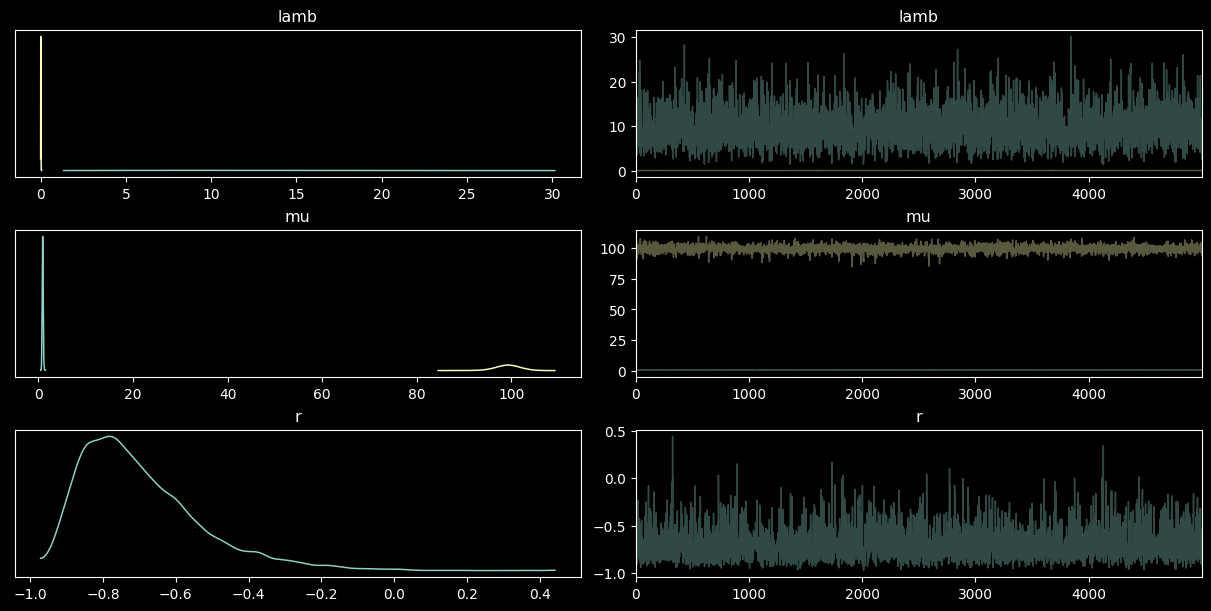

In [11]:
arviz.plot_trace(arviz.from_numpyro(mcmc));

In [12]:
# Pearson Correlation Coefficient: c_{ij} / c{ii}c{jj}
cor_coef = np.corrcoef(y[:,0], y[:,1])
cor_coef

array([[ 1.        , -0.81096708],
       [-0.81096708,  1.        ]])

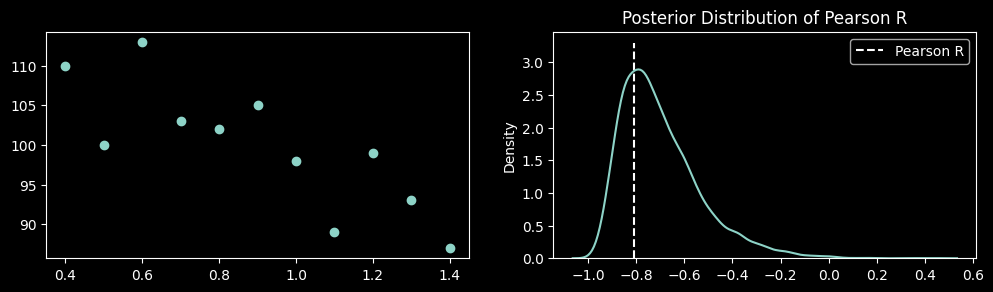

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,3))

axes[0].scatter(y[:,0], y[:,1]);
ax = axes[1]
ax = sns.kdeplot(s['r'], )
ax.vlines(cor_coef[0,1] , ymin=0, ymax=3.3, linestyles='--', label='Pearson R');
ax.legend();
ax.set(title='Posterior Distribution of Pearson R');

## Exercise 5.1
1. The second data set is just the first data set repeated twice. Interpret the differences in the posterior distribution for $r$.
2. Do you find the priors on $\mu$ reasonable?
3. The model assumes that the valeus $y$ are observed with perfect accuracy. How practical is this? Chapter 5.2 deals with this issue.

# 5.2 Pearson correlationi with uncertainty

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$

$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$

$$ r \sim \text{Uniform} (-1, 1) $$

$$ y_{i} \sim \text{MvGaussian} \bigg((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 &\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1}\bigg)  $$

$$ x_{ij} \sim \text{Gaussian}(y_{ij},\lambda_{j}^e) $$


In [14]:
def model52(y, sigma_obs):
    r = numpyro.sample('r', dist.Uniform(-1, 1))
    with numpyro.plate('mu:2', size=2):
        mu = numpyro.sample('mu', dist.Normal(0, scale=1/jnp.sqrt(0.001)))
        lamb = numpyro.sample('lamb', dist.Gamma(0.001, 0.001))
    #
    
    sig = numpyro.deterministic('sigma', 1./jnp.sqrt(lamb))
    cov = jnp.array([[1./lamb[0],          sig[0] * sig[1] * r], 
                     [sig[0]*sig[1]*r,     1./lamb[1]]])
    
    cov_obs = jnp.array([[sigma_obs[0]**2, 0], [0, sigma_obs[1]**2]])
    
    with numpyro.plate(f'Y:{y.size}', size=len(y)):
        # obs with noise
        ywn = numpyro.sample('ywn', dist.MultivariateNormal(mu, covariance_matrix=cov))
        # observation without noise
        y = numpyro.sample('y', dist.MultivariateNormal(ywn, cov_obs), obs=y)

In [15]:
sigma_obs = jnp.array([0.03, 1])

In [16]:
kernel = NUTS(model52)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, y, sigma_obs)
mcmc.print_summary()

sample: 100%|██████████| 16000/16000 [00:20<00:00, 793.89it/s, 15 steps of size 3.13e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   lamb[0]      9.69      4.19      9.05      3.21     15.97  17588.36      1.00
   lamb[1]      0.02      0.01      0.02      0.01      0.03  18309.83      1.00
     mu[0]      0.92      0.11      0.92      0.74      1.09  16270.49      1.00
     mu[1]     99.22      2.64     99.31     95.01    103.57  17289.18      1.00
         r     -0.70      0.17     -0.74     -0.94     -0.47  13918.07      1.00
  ywn[0,0]      0.80      0.03      0.80      0.75      0.85  35315.71      1.00
  ywn[0,1]    101.98      0.99    101.97    100.39    103.64  39641.07      1.00
  ywn[1,0]      1.00      0.03      1.00      0.95      1.05  34978.11      1.00
  ywn[1,1]     97.99      0.99     97.99     96.25     99.53  33700.58      1.00
  ywn[2,0]      0.51      0.03      0.51      0.46      0.55  31456.38      1.00
  ywn[2,1]    100.25      0.99    100.26     98.57    101.80  36020.60      1.00
  ywn[3,0]      0.90      0

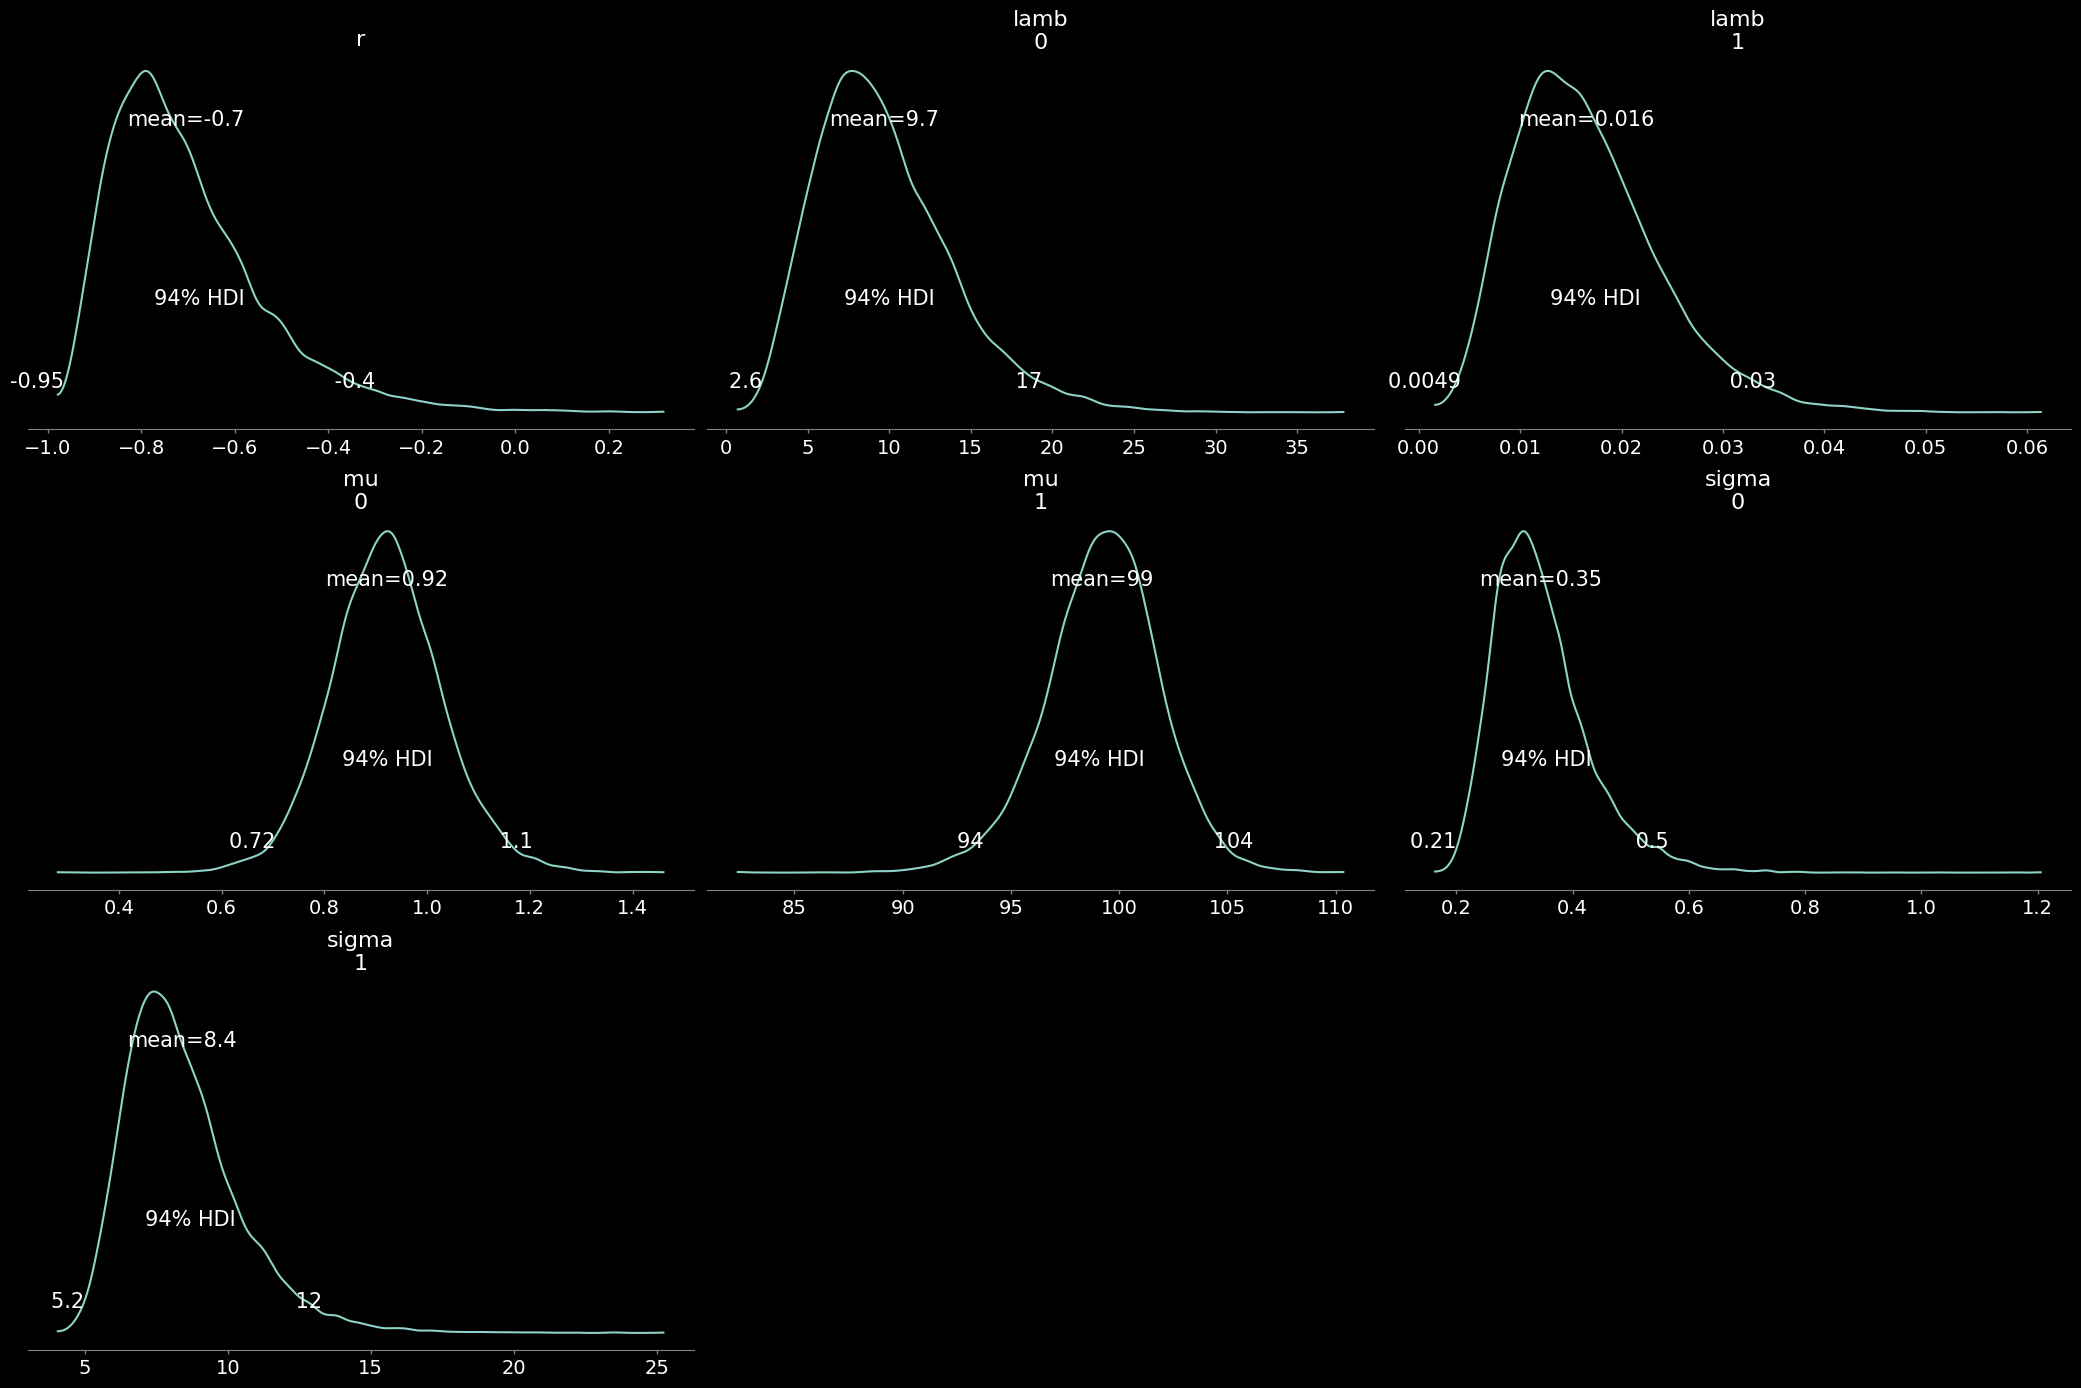

In [17]:
azdata = arviz.from_numpyro(mcmc)
arviz.plot_posterior(azdata, var_names=['r', 'lamb', 'mu', 'sigma']);

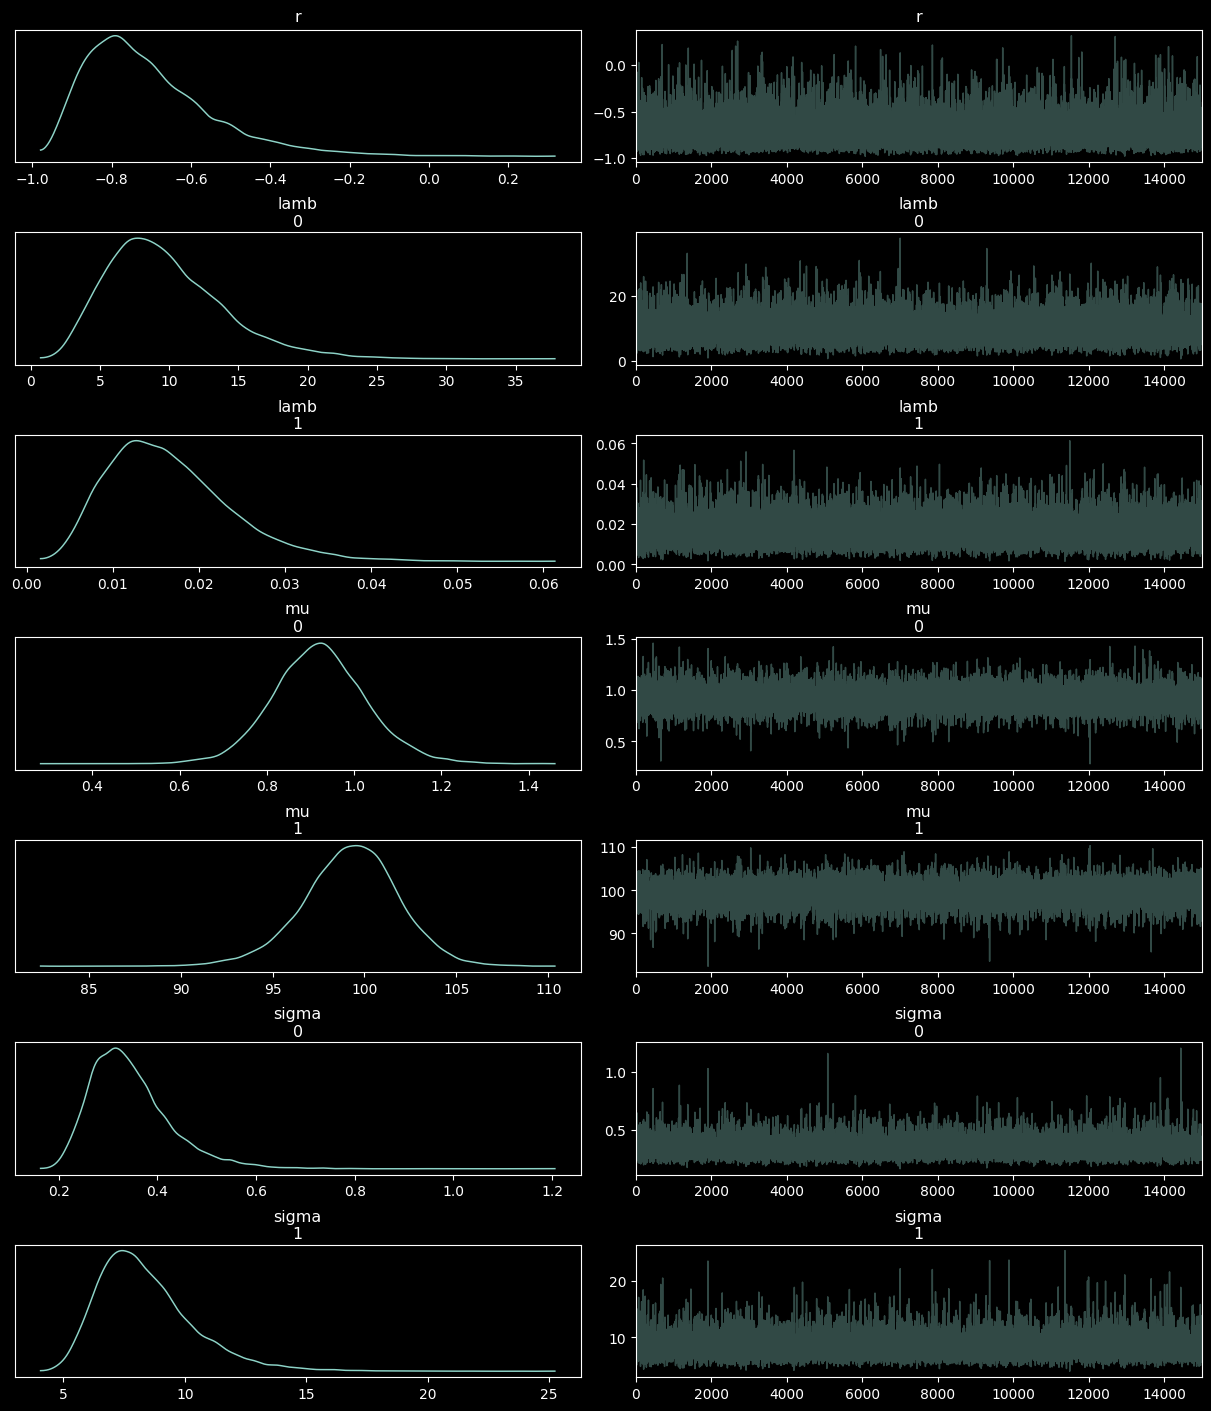

In [18]:
arviz.plot_trace(azdata, var_names=['r', 'lamb', 'mu', 'sigma'], compact=False);

In [19]:
s = mcmc.get_samples()

Posterior Mean of R distrib. =  -0.7046787
The Pearson correlation R    =  -0.8109670756358501


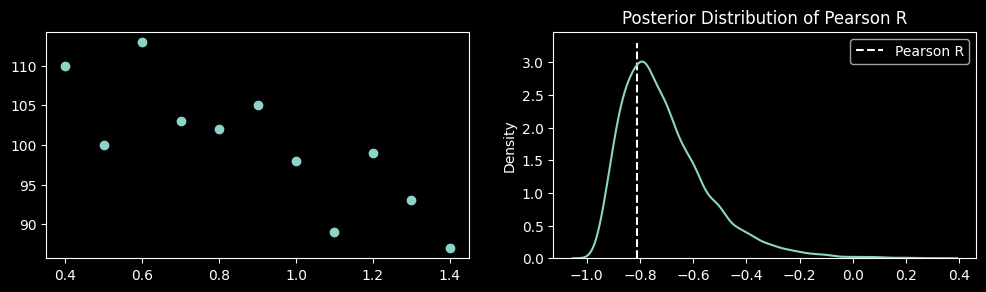

In [20]:
fig, axes = plt.subplots(1,2, figsize=(12,3))

axes[0].scatter(y[:,0], y[:,1]);
ax = axes[1]
ax = sns.kdeplot(s['r'], )
ax.vlines(cor_coef[0,1] , ymin=0, ymax=3.3, linestyles='--', label='Pearson R');
ax.legend();
ax.set(title='Posterior Distribution of Pearson R');
print('Posterior Mean of R distrib. = ', s['r'].mean())
print('The Pearson correlation R    = ', cor_coef[0, 1])

## Exercise 5.2
1. Compare the results with those obtained earlier for the model without any account of uncertainty in measurement.
2. Generate results for the second data set, which changes $\sigma_2^e = 10$ for the IQ measurement. Compare these results with those obtained assuming $\sigma_2^e = 1$.
3. How could the assumption of known uncertainty for each variable to the case where the uncertainty is unknown?
4. The graphical model assumes the uncertainty for each variable is the same for all observations. How could this assumption be relaxed to the case where, for example, extreme IQs are less accurately measured than IQs in the middle of the standard distribution?
    - how about: sigma = a + b*IQ, b > 0

---

# 5.3 The kappa coefficient of agreement

skip.

---

# 5.4 Change detection in time series data

Detecting a single change point in time series.

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$

$$ \lambda \sim \text{Gamma} (.001, .001)  $$

$$ \tau \sim \text{Uniform} (0, t_{max}) $$

$$ c_{i} \sim \begin{cases} \text{Gaussian}(\mu_{1}, \lambda), & \text{if $t_{i} \lt \tau$} \\ \text{Gaussian}(\mu_{2}, \lambda), & \text{if $t_{i} \ge \tau$} \end{cases} $$

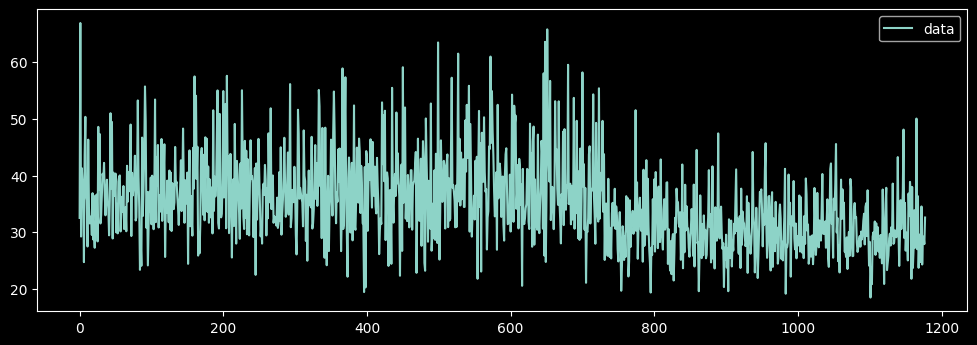

In [21]:
data = pd.read_csv('changepointdata.csv')
time_index = jnp.arange(0, len(data))

data.plot(figsize=(12,4));

In [22]:
# first try as written in the book's website
def model54(data, time_index):
    with numpyro.plate('mu:2', size=2):
        mu = numpyro.sample('mu', dist.Normal(0, scale=1./jnp.sqrt(0.001)))
#     lamb = numpyro.sample('lamb', dist.Gamma(0.001, 0.001))
    sigma2 = numpyro.sample('sigma2', dist.InverseGamma(0.001, 0.001))
    sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma2))
    
    t_max = time_index[-1] + 1
    tau_01 = numpyro.sample('tau01', dist.Uniform(0, 1))
    tau = numpyro.deterministic('tau', tau_01 * t_max)

    mus = jnp.where(time_index < tau, mu[0], mu[1])
    with numpyro.plate(f'y:{data.size}', size=len(data)):
        y = numpyro.sample('y', dist.Normal(mus, scale=sigma), obs=data)

In [23]:
kernel = NUTS(model54)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, data.data.values, time_index)
mcmc.print_summary()

sample: 100%|██████████| 16000/16000 [01:36<00:00, 166.27it/s, 1023 steps of size 9.18e-04. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]     37.69      0.45     37.76     36.96     38.13      5.66      1.19
     mu[1]     29.95      1.46     30.42     28.25     31.17      6.97      1.17
    sigma2     48.85      4.65     47.68     43.29     54.34      6.61      1.24
     tau01      0.65      0.04      0.62      0.62      0.72      3.33      1.58

Number of divergences: 0


In [ ]:
s = mcmc.get_samples()
azdata = arviz.from_numpyro(mcmc)

/home/yndk/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


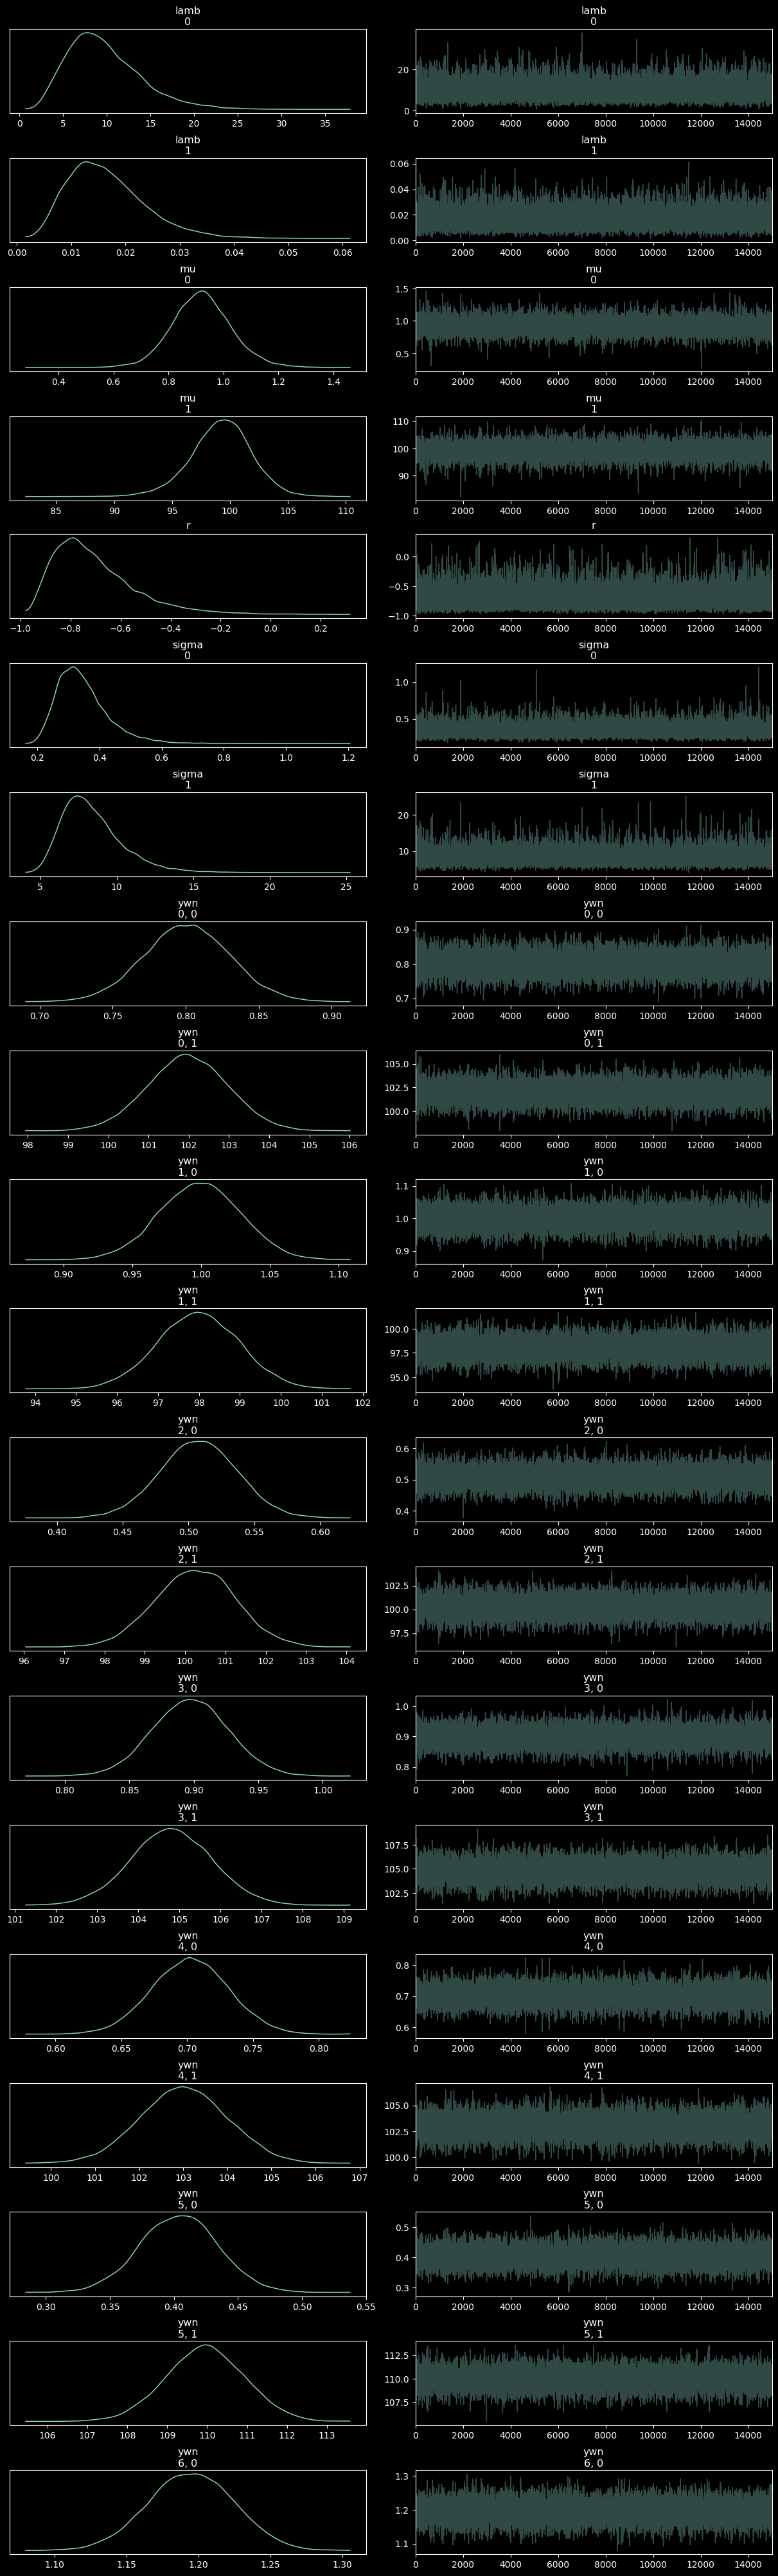

In [24]:
arviz.plot_trace(azdata, compact=False);

---

In [25]:
data.mean(), data.std()

(data    35.11836
 dtype: float64,
 data    7.707402
 dtype: float64)

In [26]:
def model54(data, time_index):
    with numpyro.plate('mu:2', size=2):
        mu0 = numpyro.sample('mu0', dist.Normal(0, 1))
        mu = numpyro.deterministic('mu', mu0 * 7.7 + 35.)  # 
        
    sigma = numpyro.sample('sigma', dist.Uniform(2, 14)) 
    
    t_max = time_index[-1] + 1
    tau_01 = numpyro.sample('tau01', dist.Uniform(0, 1))
    tau = numpyro.deterministic('tau', tau_01 * t_max)

    mus = jnp.where(time_index < tau, mu[0], mu[1])
    with numpyro.plate(f'y:{data.size}', size=len(data)):
        y = numpyro.sample('y', dist.Normal(mus, scale=sigma), obs=data)

In [27]:
kernel = NUTS(model54)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, data.data.values, time_index)
mcmc.print_summary()

sample: 100%|██████████| 16000/16000 [01:35<00:00, 166.85it/s, 1023 steps of size 9.21e-04. acc. prob=0.81]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu0[0]      0.38      0.03      0.38      0.32      0.43   1293.29      1.00
    mu0[1]     -0.57      0.04     -0.57     -0.64     -0.51    323.07      1.00
     sigma      6.84      0.14      6.84      6.61      7.07    532.72      1.00
     tau01      0.62      0.00      0.62      0.62      0.62    529.17      1.00

Number of divergences: 0


In [ ]:
s = mcmc.get_samples()
azdata = arviz.from_numpyro(mcmc)

/home/yndk/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


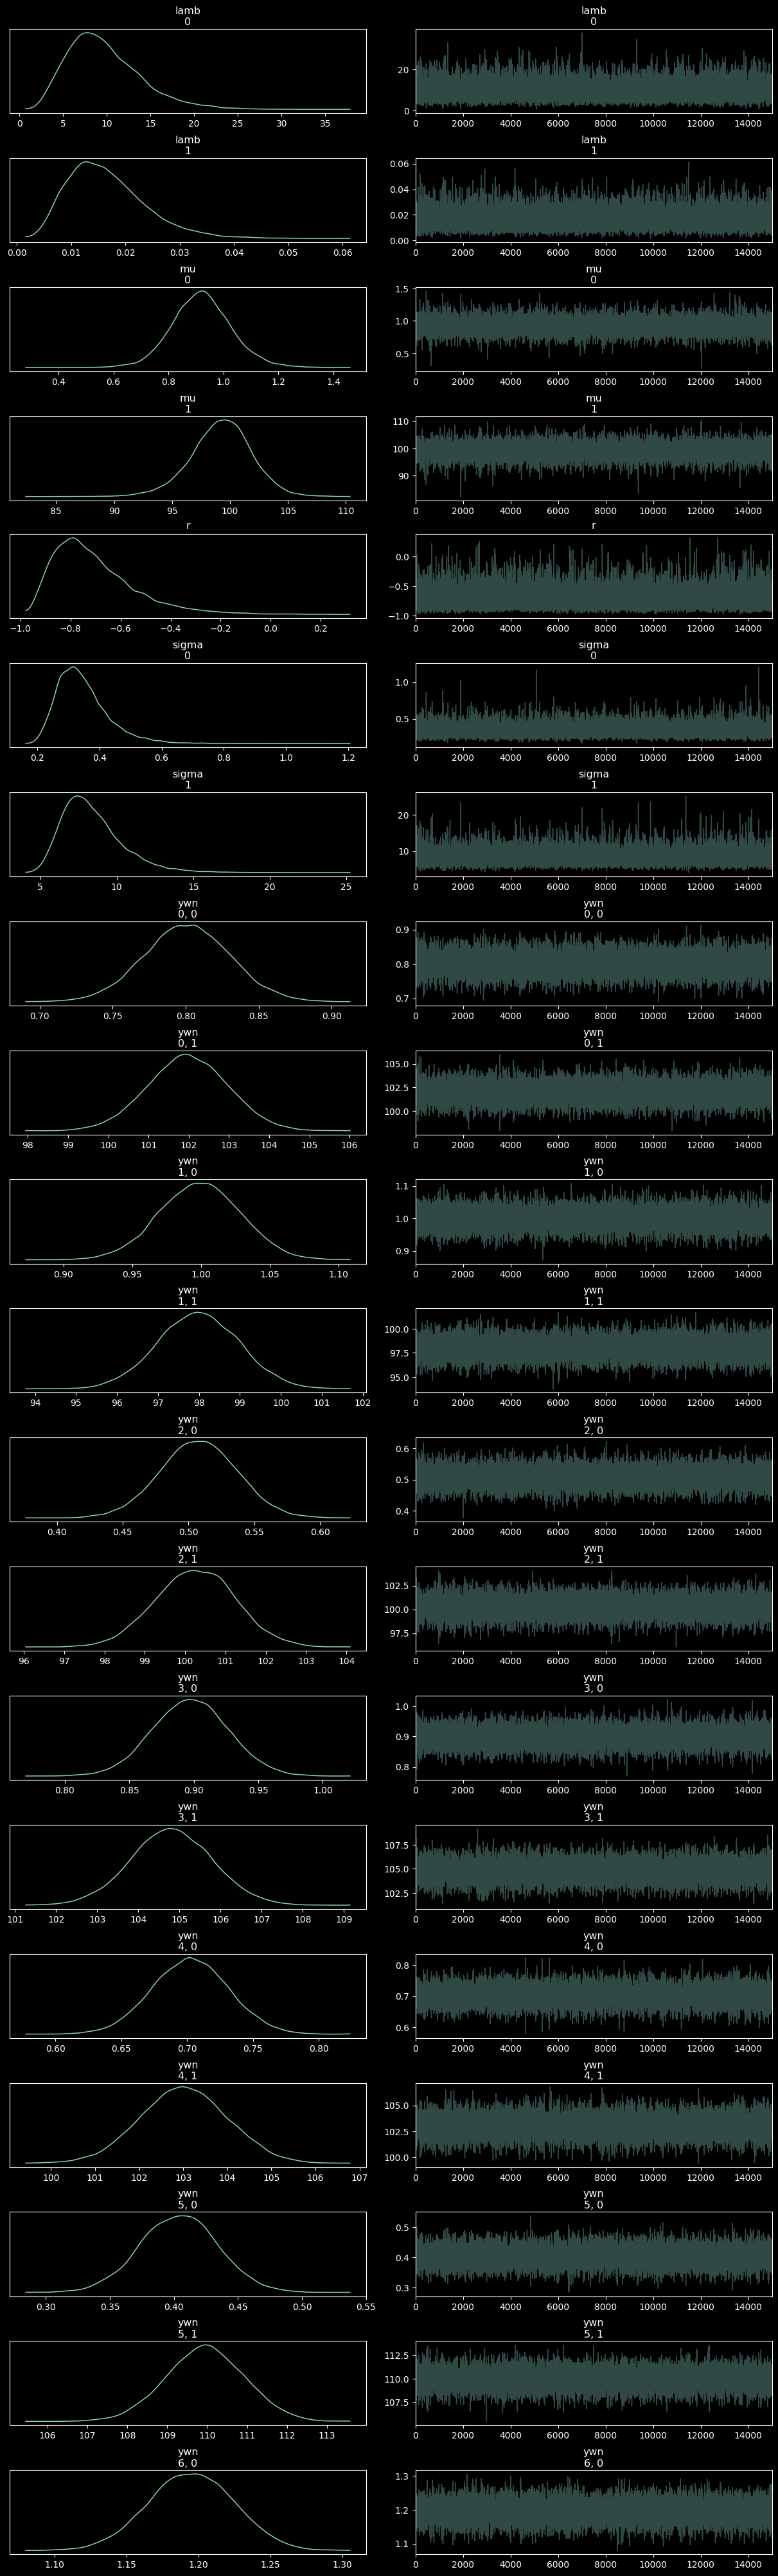

In [28]:
arviz.plot_trace(azdata, compact=False);

---

In [29]:
# thir try
def model54(data, time_index):
    with numpyro.plate('mu:2', size=2):
        mu0 = numpyro.sample('mu0', dist.Normal(0, 1))
        mu = numpyro.deterministic('mu', mu0 * 35.)  # just make it larger area
        
    sigma = numpyro.sample('sigma', dist.Uniform(0, 14)) 
    
    t_max = time_index[-1] + 1
    tau_01 = numpyro.sample('tau01', dist.Uniform(0, 1))
    tau = numpyro.deterministic('tau', tau_01 * t_max)

    mus = jnp.where(time_index < tau, mu[0], mu[1])
    with numpyro.plate(f'y:{data.size}', size=len(data)):
        y = numpyro.sample('y', dist.Normal(mus, scale=sigma), obs=data)

In [30]:
kernel = NUTS(model54)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, data.data.values, time_index)
mcmc.print_summary()

sample: 100%|██████████| 16000/16000 [01:37<00:00, 164.62it/s, 1023 steps of size 1.19e-03. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu0[0]      1.08      0.01      1.08      1.07      1.09   1270.49      1.00
    mu0[1]      0.87      0.01      0.87      0.86      0.89    963.83      1.00
     sigma      6.85      0.15      6.85      6.60      7.08    363.33      1.00
     tau01      0.62      0.00      0.62      0.62      0.62    650.48      1.00

Number of divergences: 0


In [37]:
s = mcmc.get_samples()
azdata = arviz.from_numpyro(mcmc)

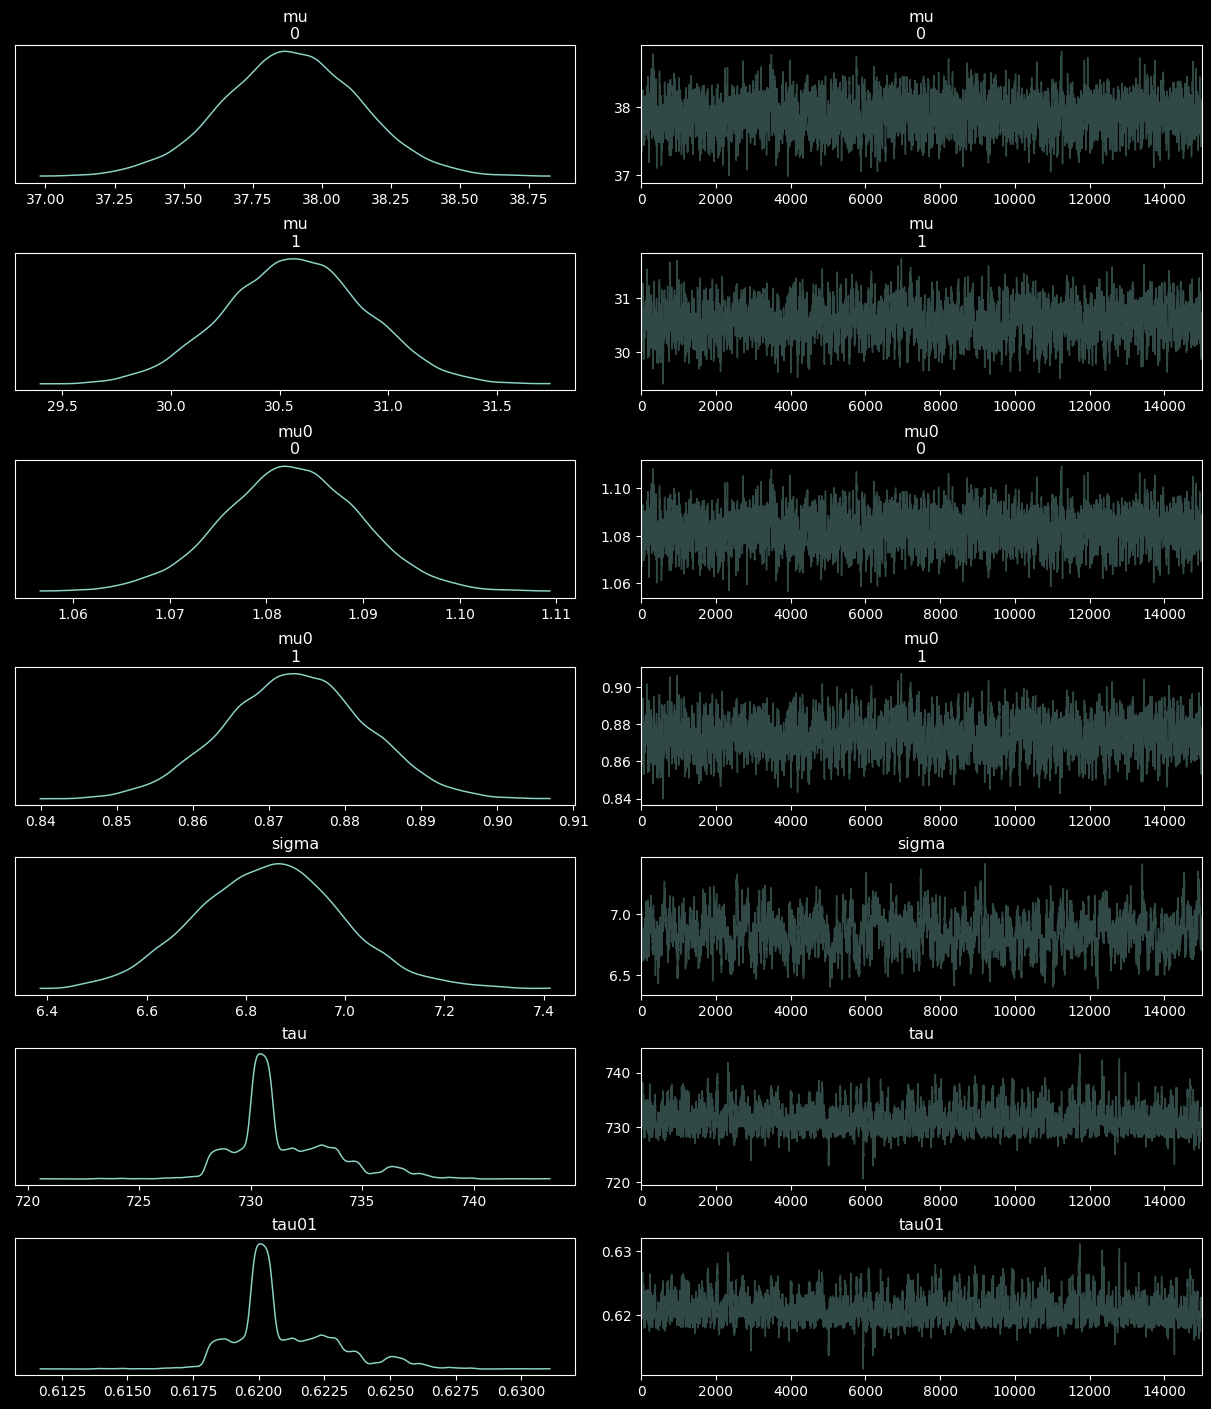

In [38]:
arviz.plot_trace(azdata, compact=False);

---

In [53]:
data['stz'] = (data['data'].values - data.data.mean()) / data.data.std()

In [56]:
data.mean(), data.std()

(data    3.511836e+01
 stz     2.412709e-17
 dtype: float64,
 data    7.707402
 stz     1.000000
 dtype: float64)

In [57]:
# fourth try, data standardized
def model54(data, time_index):
    with numpyro.plate('mu:2', size=2):
        mu = numpyro.sample('mu0', dist.Normal(0, 1))
        
    sigma = numpyro.sample('sigma', dist.Uniform(.1, 4)) 
    
    t_max = time_index[-1] + 1
    tau_01 = numpyro.sample('tau01', dist.Uniform(0, 1))
    tau = numpyro.deterministic('tau', tau_01 * t_max)

    mus = jnp.where(time_index < tau, mu[0], mu[1])
    with numpyro.plate(f'y:{data.size}', size=len(data)):
        y = numpyro.sample('y', dist.Normal(mus, scale=sigma), obs=data)

In [58]:
kernel = NUTS(model54)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, data.stz.values, time_index)
mcmc.print_summary()

sample: 100%|██████████| 16000/16000 [01:36<00:00, 165.23it/s, 1023 steps of size 9.03e-04. acc. prob=0.79]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu0[0]      0.36      0.03      0.36      0.31      0.41    973.56      1.00
    mu0[1]     -0.59      0.04     -0.59     -0.65     -0.52    284.15      1.00
     sigma      0.89      0.02      0.89      0.86      0.92    288.87      1.00
     tau01      0.62      0.00      0.62      0.62      0.62    661.21      1.00

Number of divergences: 0


In [66]:
# more warmup results in better n_eff
kernel = NUTS(model54)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=15000, num_chains=1)
#
mcmc.run(rng_key, data.stz.values, time_index)
mcmc.print_summary()

sample: 100%|██████████| 20000/20000 [02:00<00:00, 166.38it/s, 1023 steps of size 7.53e-04. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    mu0[0]      0.36      0.03      0.36      0.31      0.41    581.96      1.00
    mu0[1]     -0.59      0.04     -0.59     -0.66     -0.52    485.76      1.00
     sigma      0.89      0.02      0.89      0.86      0.92    506.37      1.00
     tau01      0.62      0.00      0.62      0.62      0.62    291.58      1.00

Number of divergences: 0


In [67]:
s = mcmc.get_samples()
azdata = arviz.from_numpyro(mcmc)

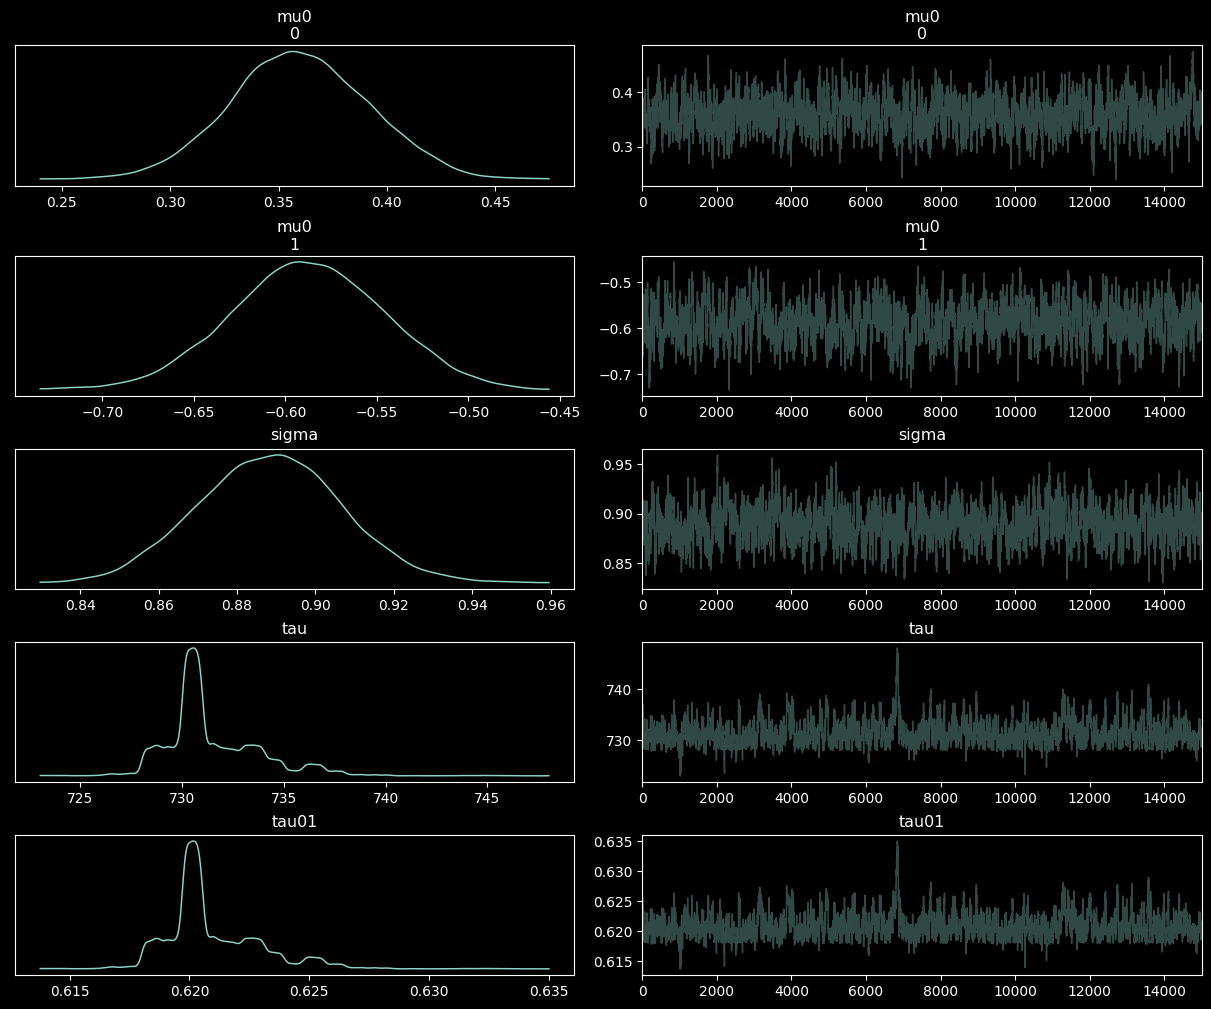

In [68]:
arviz.plot_trace(azdata, compact=False);

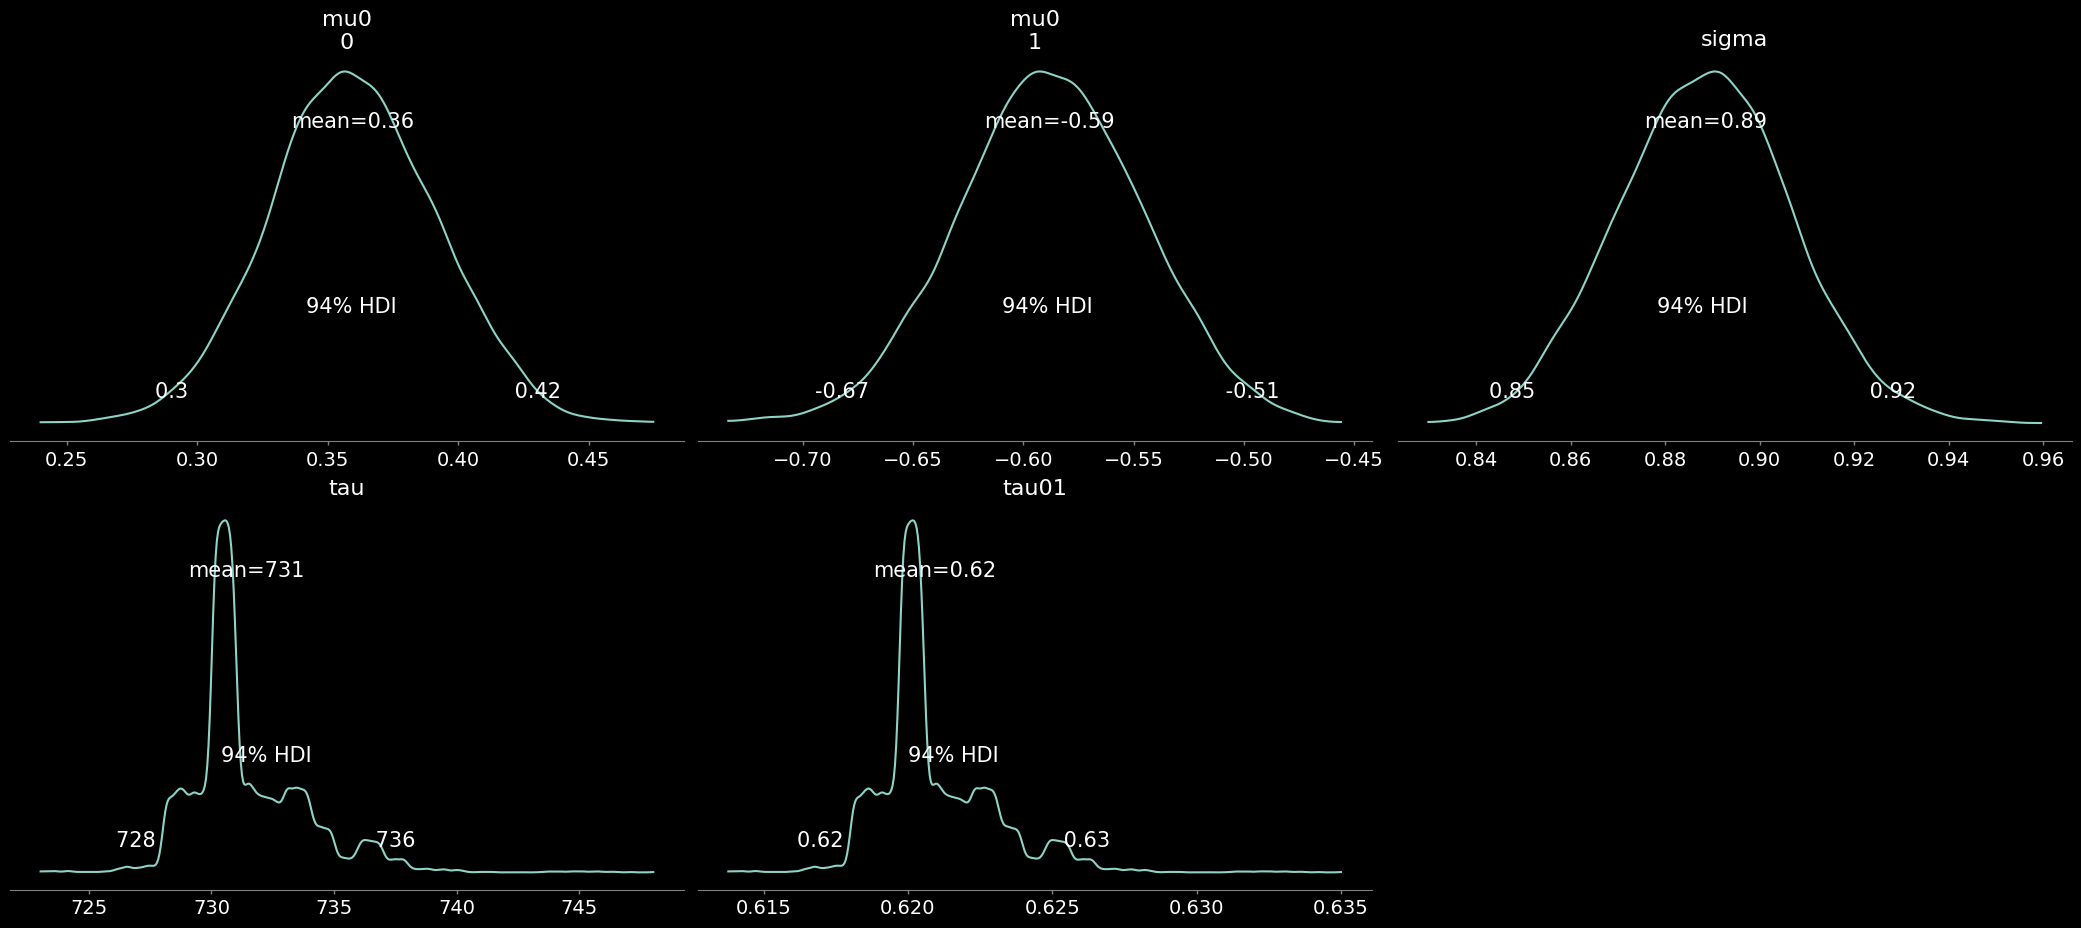

In [69]:
arviz.plot_posterior(azdata);

In [70]:
s = mcmc.get_samples()

mu = s['mu0'].mean(axis=0); mu
tau = s['tau'].mean(); tau

DeviceArray(731.44055, dtype=float32)

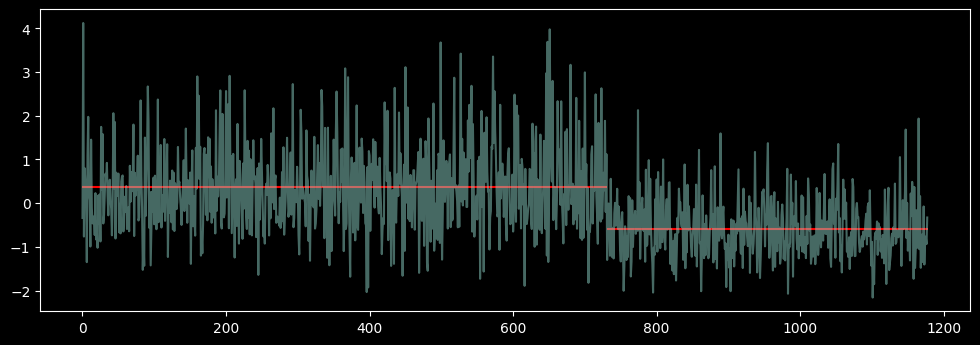

In [71]:
plt.figure(figsize=(12,4))
plt.plot(data.stz, alpha=.5)
plt.hlines(y=mu[0], xmin=0, xmax=tau, colors='r')
plt.hlines(y=mu[1], xmin=tau, xmax=len(data), colors='r');

## Exercise 5.4

3. Imagine that you apply this model to a dataset that has two change points instead of one. What could happen?

# 5.5 Censored Data is in a separate notebook.